## Benchmark Results Visualization

This notebook loads and visualizes the results from the LLM benchmark runs.
It can handle results stored in JSON or CSV format.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from typing import Dict, Any, List, Optional, Tuple

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (6, 8) # Default figure size

RESULTS_DIR = "./benchmarks_output"
RESULTS_BASE_NAME = "benchmark_results"

## 1. Configuration and Result File Loading
 
Specify the **directory** where your benchmark results are saved and the **base name** of the results file.
The notebook will attempt to load `.json` or `.csv` files.

In [2]:
def load_benchmark_data(results_dir: str, base_name: str) -> Optional[pd.DataFrame]:
    """
    Load benchmark results from JSON or CSV files.
    :param results_dir: Directory containing the results files.
    :param base_name: Base name of the results files (without extension).
    :return: DataFrame containing the benchmark results, or None if no files found.
    """
    path_json = Path(results_dir) / f"{base_name}.json"
    path_csv = Path(results_dir) / f"{base_name}.csv"

    try:
        if path_json.exists():
            print(f"Loading JSON: {path_json}")
            with open(path_json, 'r') as f:
                return flatten_json_results(json.load(f))
        elif path_csv.exists():
            print(f"Loading CSV: {path_csv}")
            df = pd.read_csv(path_csv)
            return reshape_csv_results(df) if 'score' not in df.columns else df.assign(score=pd.to_numeric(df['score'], errors='coerce'))
        else:
            print(f"No result files found in {results_dir}")
    except Exception as e:
        print(f"Load error: {e}")
    return None

def flatten_json_results(data: Dict[str, Dict[str, Any]]) -> pd.DataFrame:
    """
    Flatten the nested JSON structure into a DataFrame.
    :param data: Nested dictionary containing benchmark results.
    :return: DataFrame with columns for model, task, metric, sub-metric, and score.
    """
    records = []
    for model, tasks in data.items():
        if not isinstance(tasks, dict): continue
        for task, metrics in tasks.items():
            if not isinstance(metrics, dict): continue
            base = {"model": model, "task": task}
            if "error" in metrics:
                print(f"Error in {model}/{task}: {metrics['error']}")
            for metric, val in metrics.items():
                if metric == "error": continue
                if isinstance(val, dict):
                    for sub, score in val.items():
                        records.append({**base, "metric": metric, "sub_metric": sub, "score": to_float(score)})
                else:
                    records.append({**base, "metric": metric, "sub_metric": None, "score": to_float(val)})
    df = pd.DataFrame(records)
    if not df.empty:
        df["full_metric_name"] = df.apply(lambda r: f"{r['metric']}_{r['sub_metric']}" if r['sub_metric'] else r['metric'], axis=1)
    else:
        df = pd.DataFrame(columns=["model", "task", "metric", "sub_metric", "score", "full_metric_name"])
    return df

def reshape_csv_results(df: pd.DataFrame) -> pd.DataFrame:
    """
    Reshape the DataFrame from wide to long format.
    :param df: DataFrame containing benchmark results.
    :return: Reshaped DataFrame with columns for model, task, metric, sub-metric, and score.
    """
    id_vars = [col for col in ['model', 'task'] if col in df.columns]
    if not id_vars:
        if all(col in df.columns for col in ['score', 'metric']):
            df['full_metric_name'] = df.apply(lambda r: f"{r['metric']}_{r['sub_metric']}" if r.get('sub_metric') else r['metric'], axis=1)
        return df

    df_long = pd.melt(df, id_vars=id_vars, var_name='full_metric_name', value_name='score')
    df_long[['metric', 'sub_metric']] = df_long['full_metric_name'].apply(
        lambda name: pd.Series(split_metric_name(name))
    )
    df_long['score'] = pd.to_numeric(df_long['score'], errors='coerce')
    return df_long

def split_metric_name(name: str) -> Tuple[str, Optional[str]]:
    """
    Split the metric name into base metric and sub-metric.
    :param name: Full metric name (e.g., "rouge1", "bert_score_f1").
    :return: Tuple of (base metric, sub-metric) or (name, None) if no sub-metric.
    """
    parts = name.split('_', 1)
    return (parts[0], parts[1]) if len(parts) == 2 and parts[0] in ['rouge', 'bert_score'] else (name, None)

def to_float(value: Any) -> Optional[float]:
    """
    Convert a value to float, returning None if conversion fails.
    :param value: Value to convert.
    :return: Converted float value or None.
    """
    try: return float(value)
    except (ValueError, TypeError): return None

## 2. Load Benchmark Data

In [3]:
results_df = load_benchmark_data(RESULTS_DIR, RESULTS_BASE_NAME)

if results_df is not None and not results_df.empty:
    print("\nProcessed DataFrame Head:")
    print(results_df.head())
    print(f"\nDataFrame shape: {results_df.shape}")
    print("\nAvailable Models:", results_df['model'].unique())
    print("Available Tasks:", results_df['task'].unique())
    # Check if 'full_metric_name' column exists before trying to access its unique values
    if 'full_metric_name' in results_df.columns:
        print("Available Metrics (full_metric_name):", results_df['full_metric_name'].unique())
    else:
        print("Warning: 'full_metric_name' column not found in DataFrame. Plotting might be affected.")
else:
    print("No data loaded or DataFrame is empty. Cannot proceed with plotting.")
    # Create an empty DataFrame with expected columns to prevent errors in plotting functions if they are called
    results_df = pd.DataFrame(columns=["model", "task", "metric", "sub_metric", "score", "full_metric_name"])

Loading JSON: benchmarks_output\benchmark_results.json

Processed DataFrame Head:
      model                           task       metric sub_metric     score  \
0  gemma-2b  MMLU (all Subset - Templated)  exact_match       None  0.300000   
1  gemma-2b  MMLU (all Subset - Templated)     accuracy       None  0.300000   
2  gemma-2b  MMLU (all Subset - Templated)     f1_score       None  0.206061   
3  gemma-2b  MMLU (all Subset - Templated)    precision       None  0.244444   
4  gemma-2b  MMLU (all Subset - Templated)       recall       None  0.300000   

  full_metric_name  
0      exact_match  
1         accuracy  
2         f1_score  
3        precision  
4           recall  

DataFrame shape: (24, 6)

Available Models: ['gemma-2b' 'gpt2']
Available Tasks: ['MMLU (all Subset - Templated)']
Available Metrics (full_metric_name): ['exact_match' 'accuracy' 'f1_score' 'precision' 'recall'
 'rouge_rouge-l_f' 'bleu' 'meteor' 'bert_score_bertscore_precision'
 'bert_score_bertscore_recall' 

## 3. Visualizations
 
Create various plots to compare model performance.
The plotting functions below should work with the DataFrame structure produced by `load_benchmark_data`.

In [4]:
def plot_task_metrics(df: pd.DataFrame, task_name: str, metrics: List[str]) -> None:
    """
    Plot metrics for a specific task.
    :param df: DataFrame containing benchmark results.
    :param task_name: Name of the task to plot.
    :param metrics: List of metrics to plot.
    """
    if df.empty or 'task' not in df.columns: return print(f"No data for task: {task_name}")
    task_df = df[df['task'] == task_name]
    
    for metric in metrics:
        data = task_df[task_df['full_metric_name'] == metric].dropna(subset=['score'])
        if data.empty: 
            print(f"Skipping: No valid data for {task_name}/{metric}")
            continue

        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x='model', y='score', hue='model', data=data, palette="viridis", legend=False)
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
        plt.title(f"{task_name} - {metric}")
        plt.xlabel("Model"), plt.ylabel(metric)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout(), plt.show()

def plot_metric_across_tasks(df: pd.DataFrame, metric: str) -> None:
    """
    Plot a bar chart for a specific metric across all tasks.
    :param df: DataFrame containing benchmark results.
    :param metric: Metric to plot.
    """
    data = df[df['full_metric_name'] == metric].dropna(subset=['score'])
    if data.empty: return print(f"No data for metric: {metric}")
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='task', y='score', hue='model', data=data, palette="muted")
    plt.title(f"{metric} Across Tasks")
    plt.xlabel("Task"), plt.ylabel(f"{metric} Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(), plt.show()

def plot_heatmap_for_metric(df: pd.DataFrame, metric: str) -> None:
    """
    Plot a heatmap for a specific metric across models and tasks.
    :param df: DataFrame containing benchmark results.
    :param metric: Metric to plot.
    """
    data = df[df['full_metric_name'] == metric].dropna(subset=['score'])
    if data.empty: return print(f"No data for heatmap: {metric}")

    try:
        pivot = data.pivot_table(index='model', columns='task', values='score')
        if pivot.empty: return print(f"Empty heatmap for {metric}")
        plt.figure(figsize=(12, max(6, len(pivot)*0.5)))
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=.5)
        plt.title(f"Heatmap: {metric}")
        plt.xlabel("Task"), plt.ylabel("Model")
        plt.xticks(rotation=45, ha="right"), plt.yticks(rotation=0)
        plt.tight_layout(), plt.show()
    except Exception as e:
        print(f"Error in heatmap for {metric}: {e}")

## 4. Plotting


Generating All Plots


--- Task: MMLU (all Subset - Templated) ---


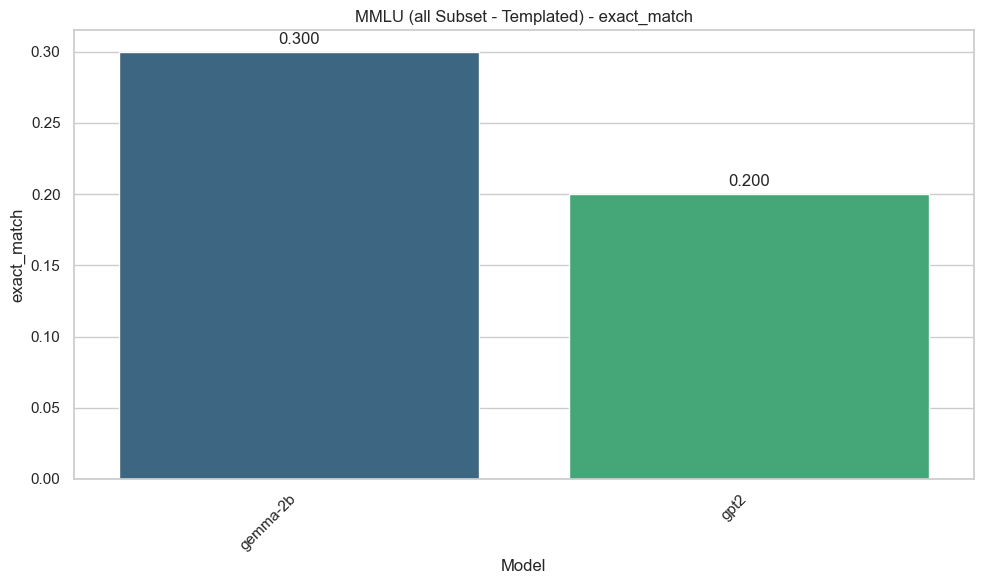

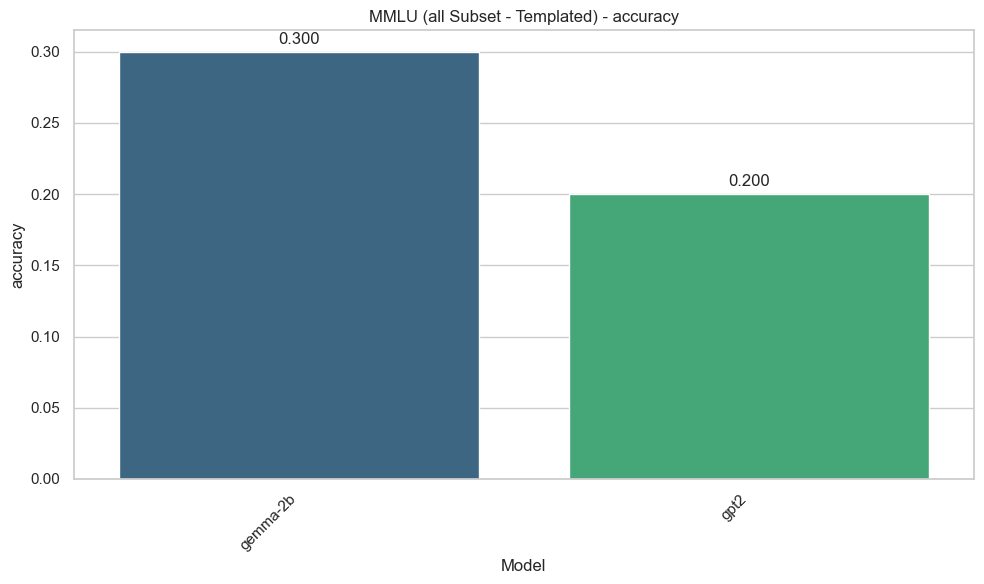

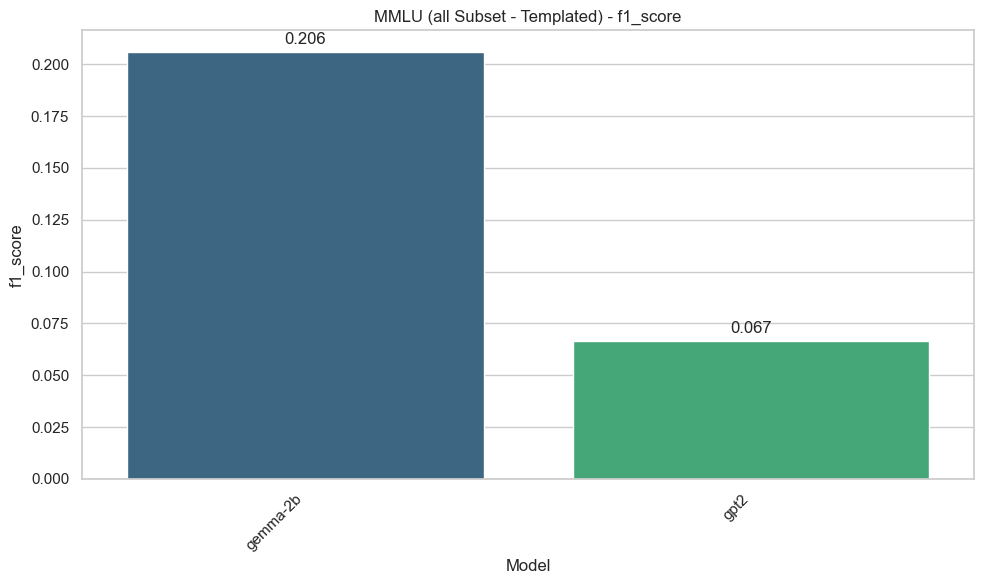

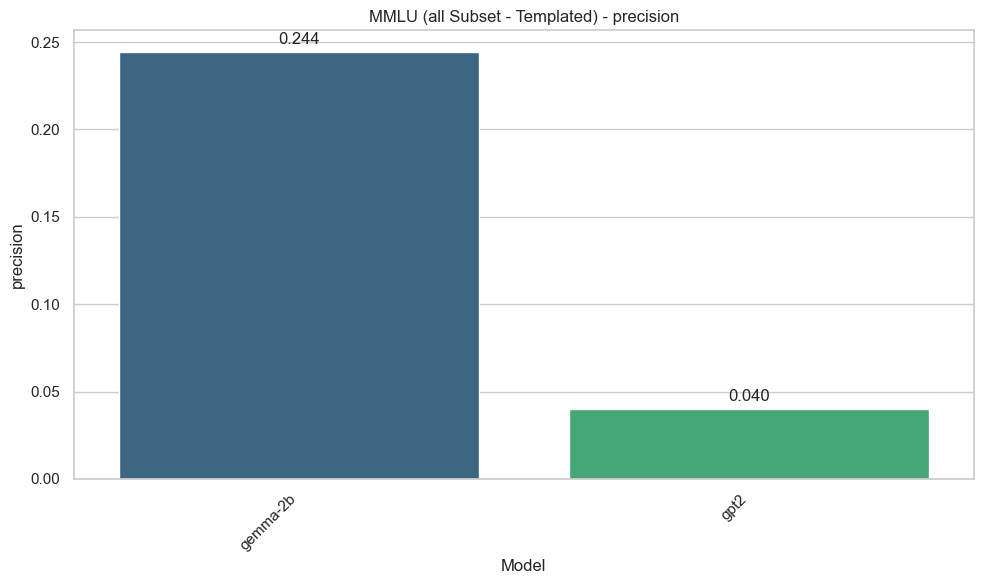

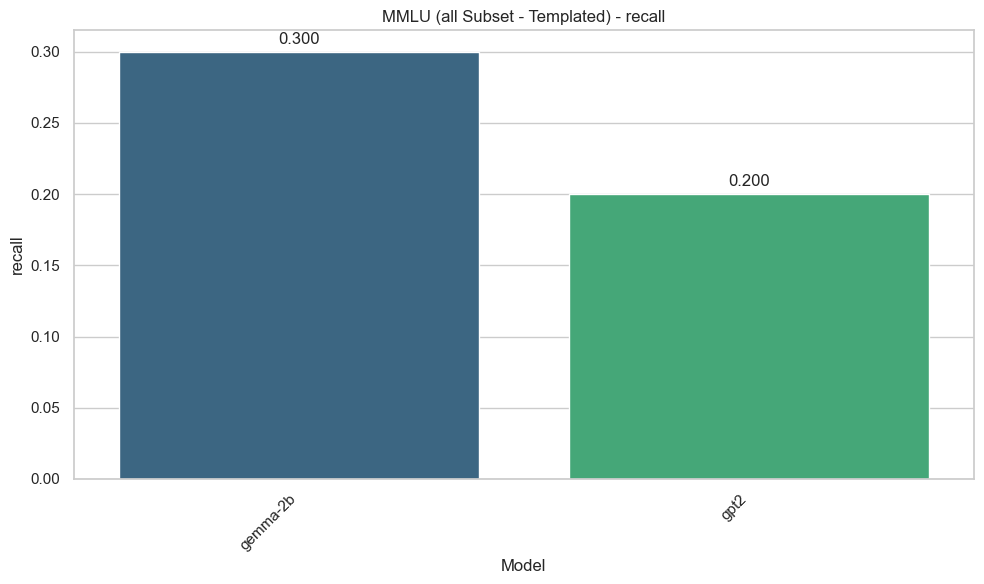

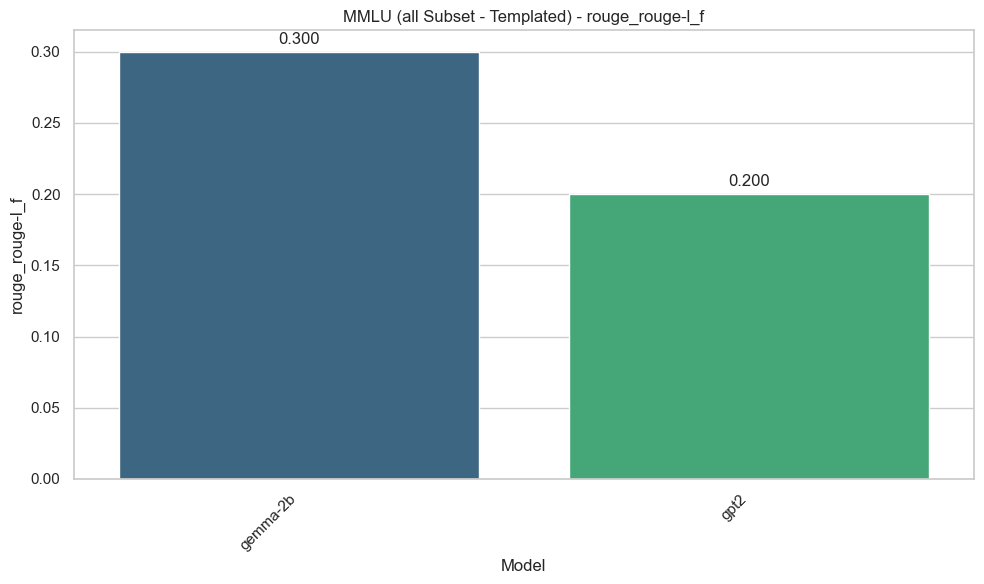

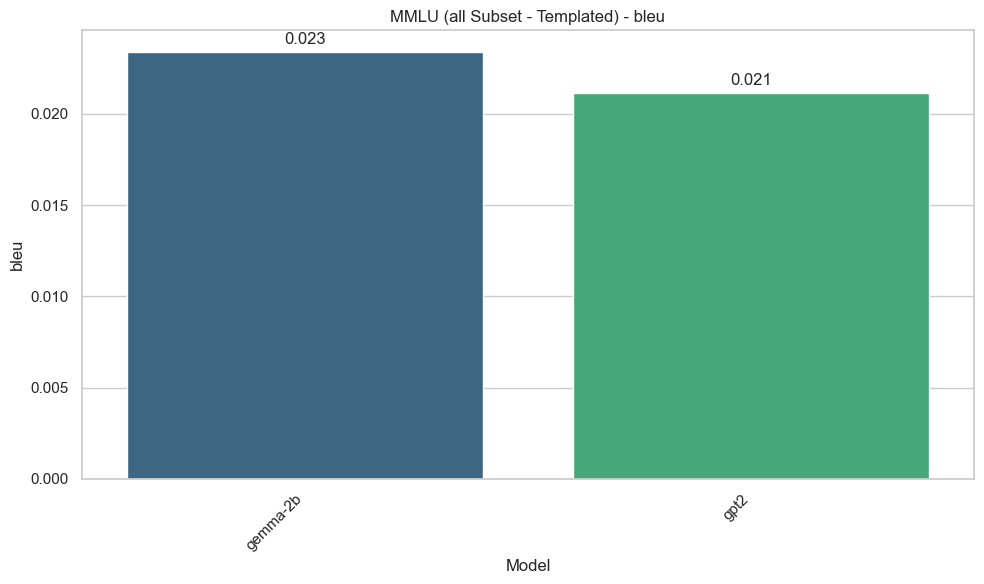

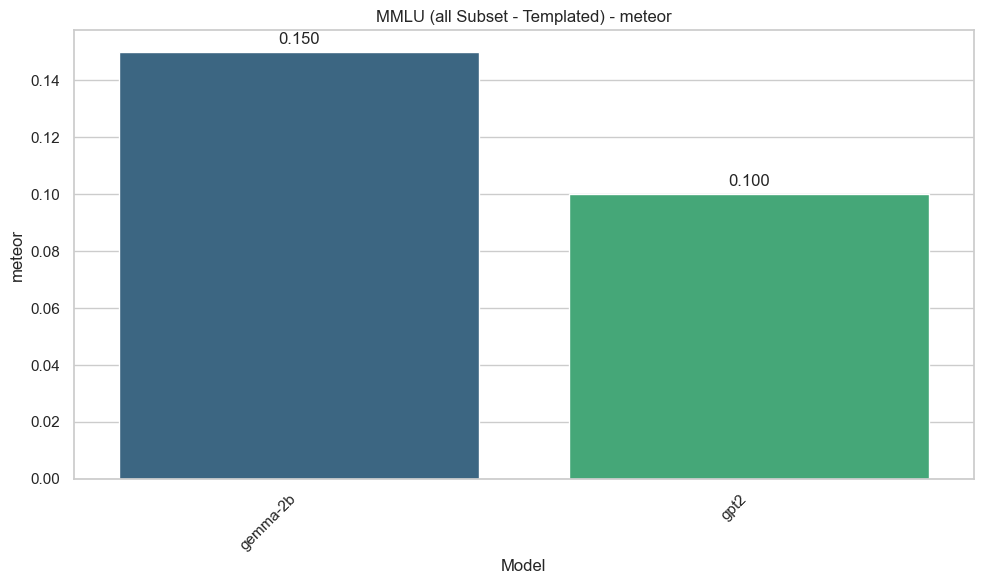

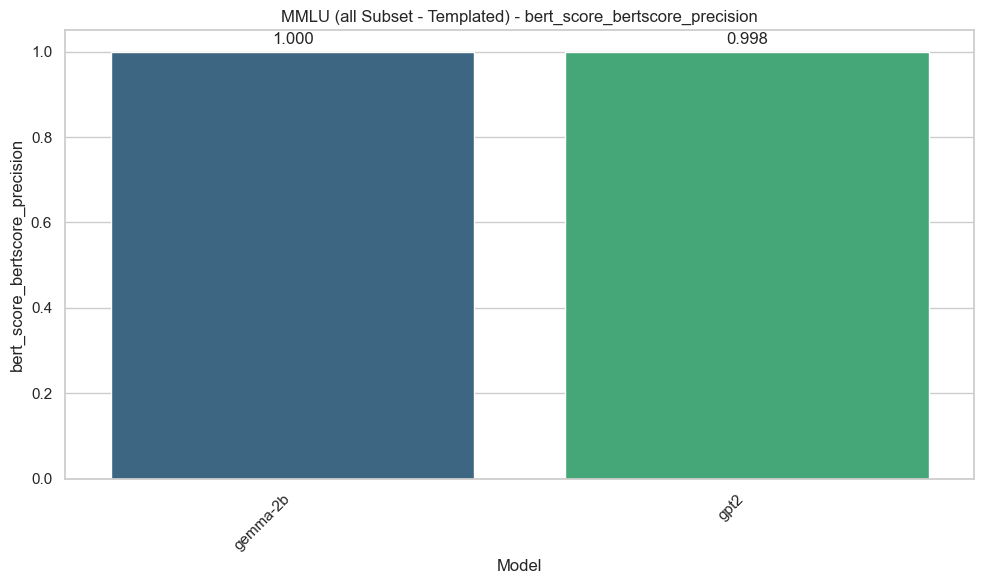

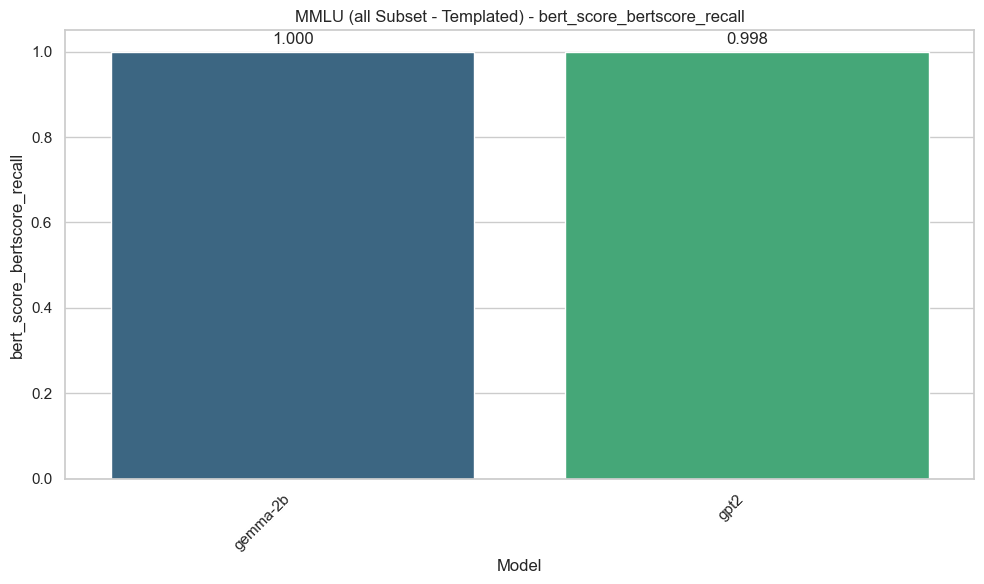

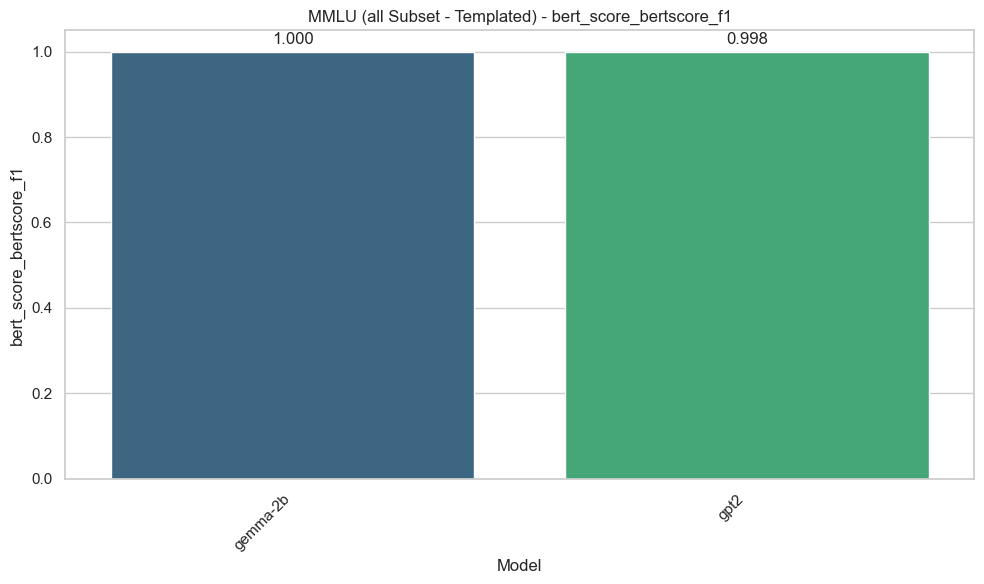

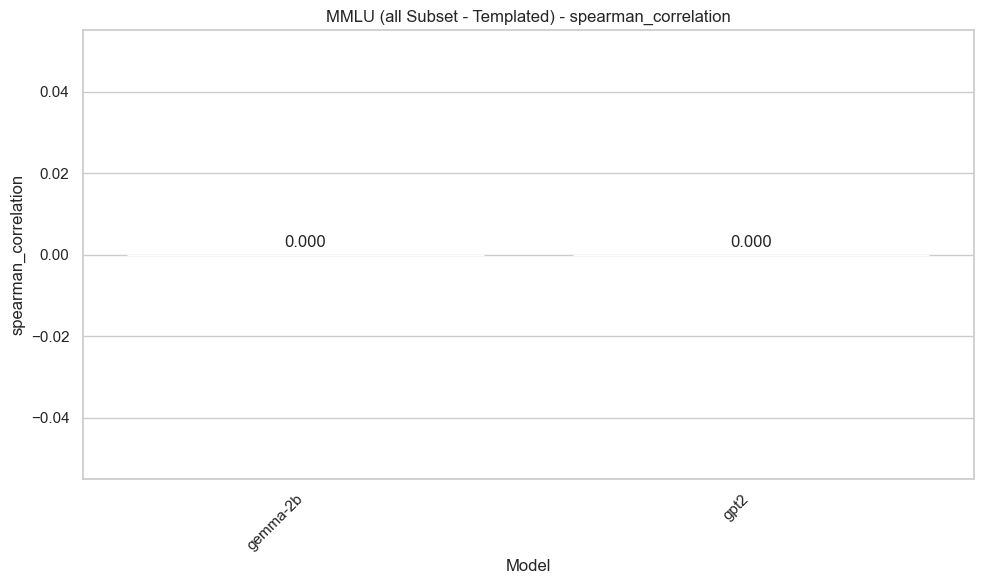


--- Plotting each metric across tasks ---

Metric: exact_match


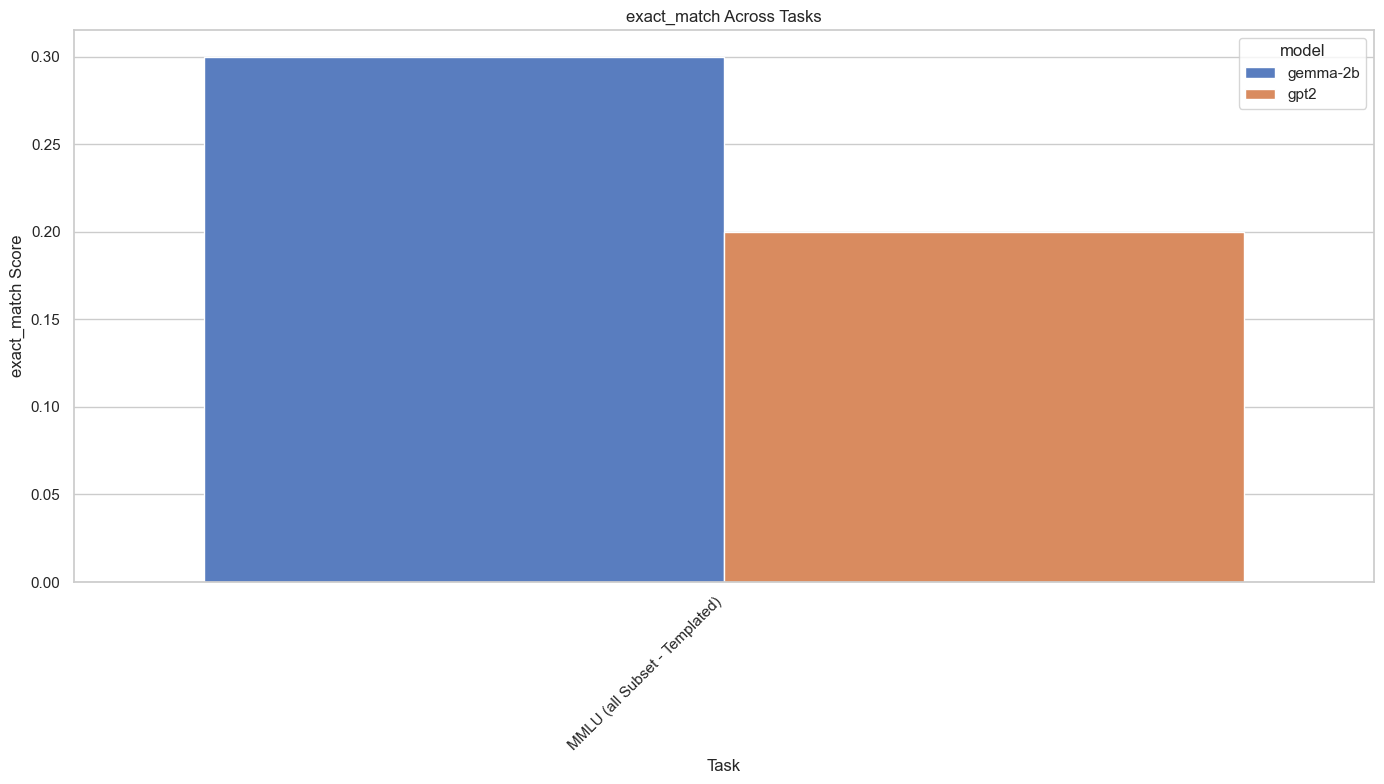


Metric: accuracy


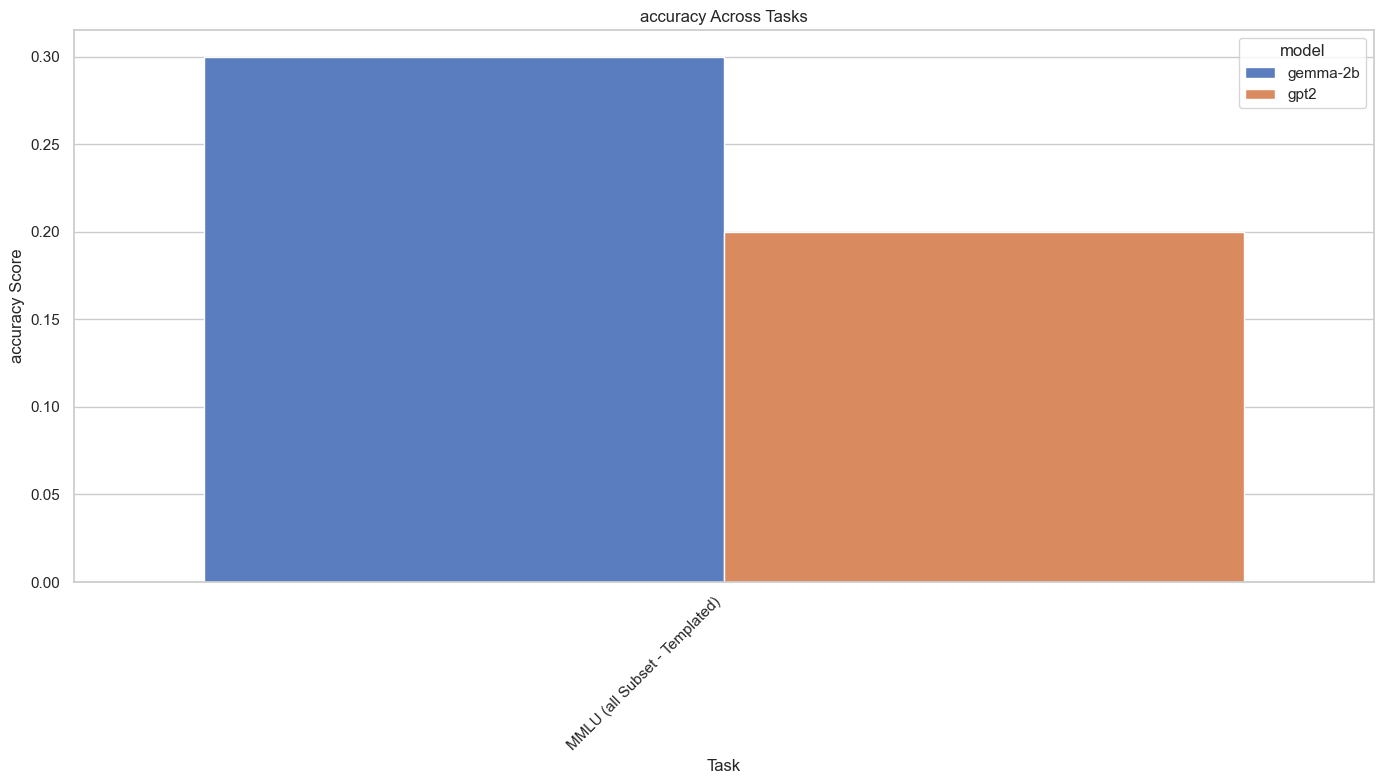


Metric: f1_score


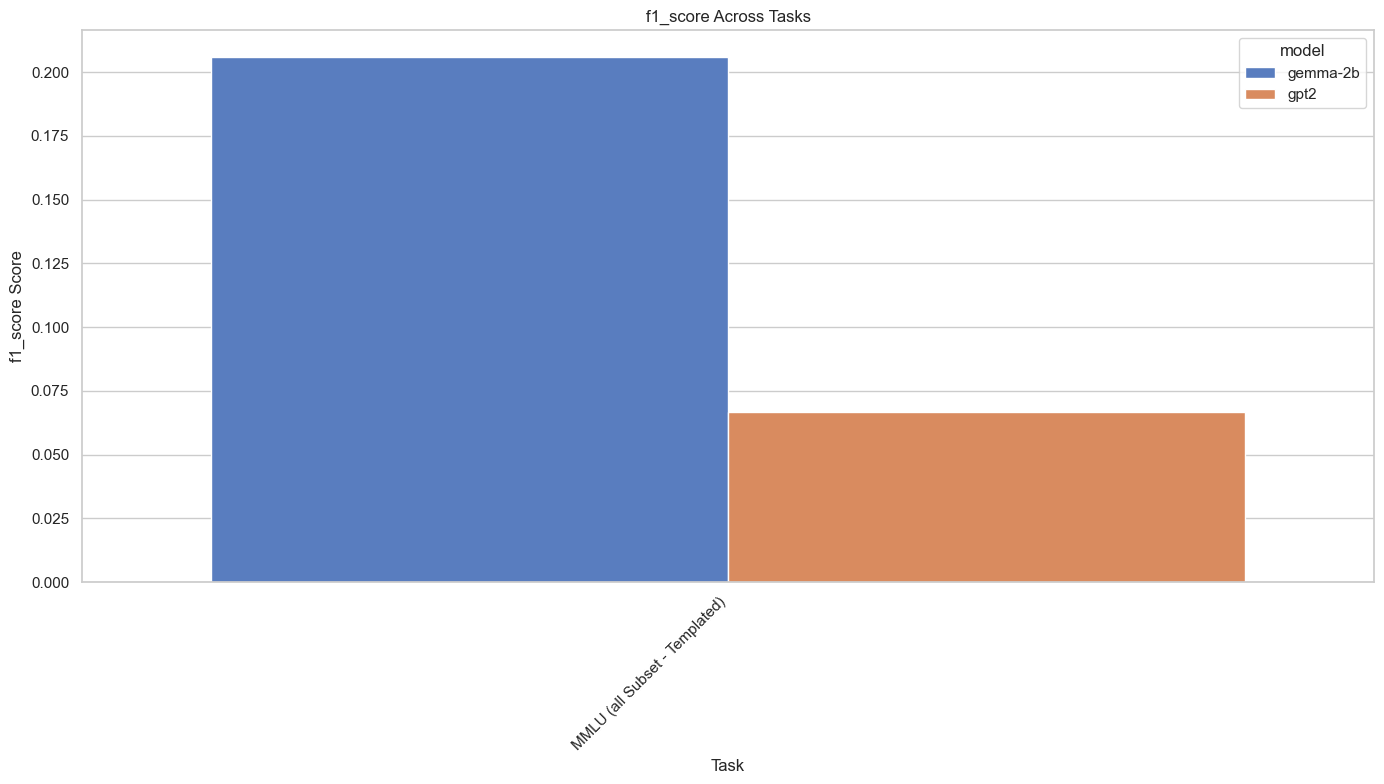


Metric: precision


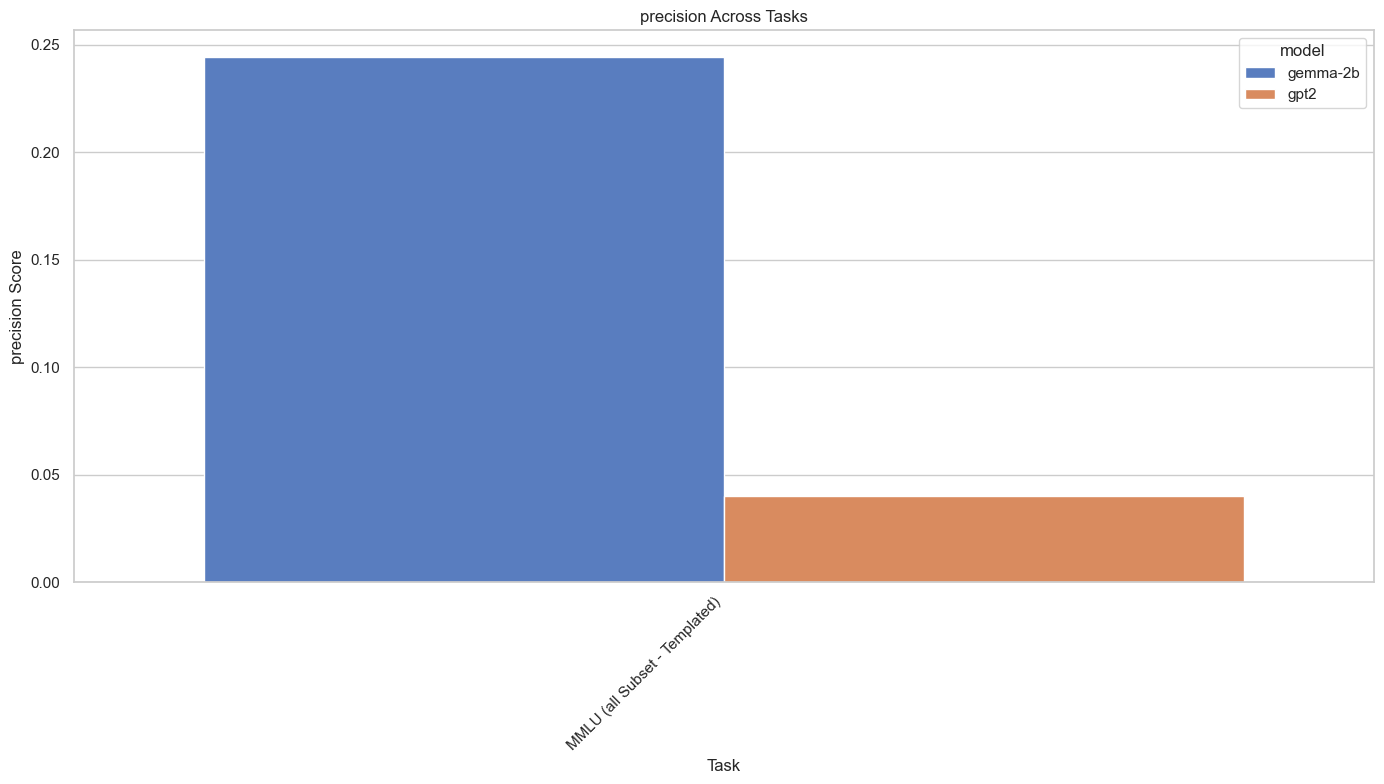


Metric: recall


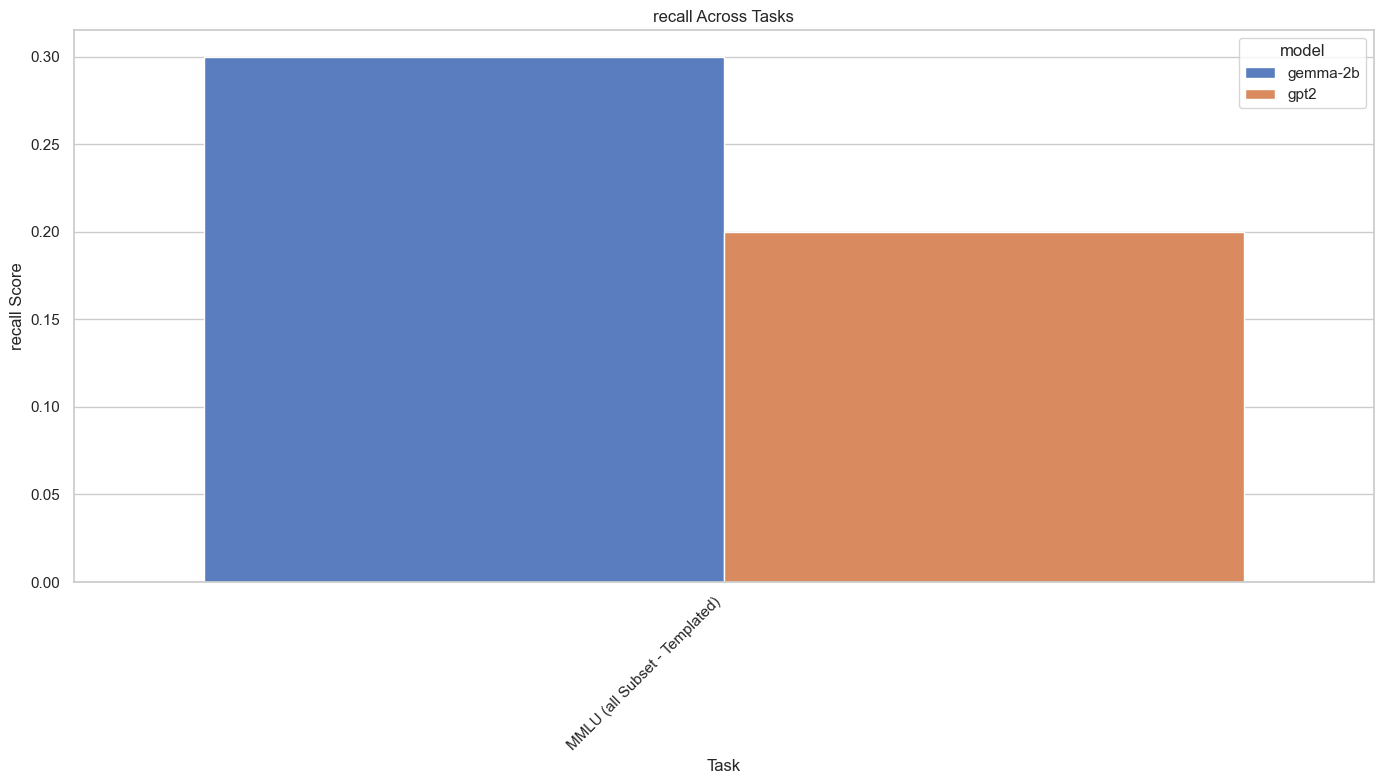


Metric: rouge_rouge-l_f


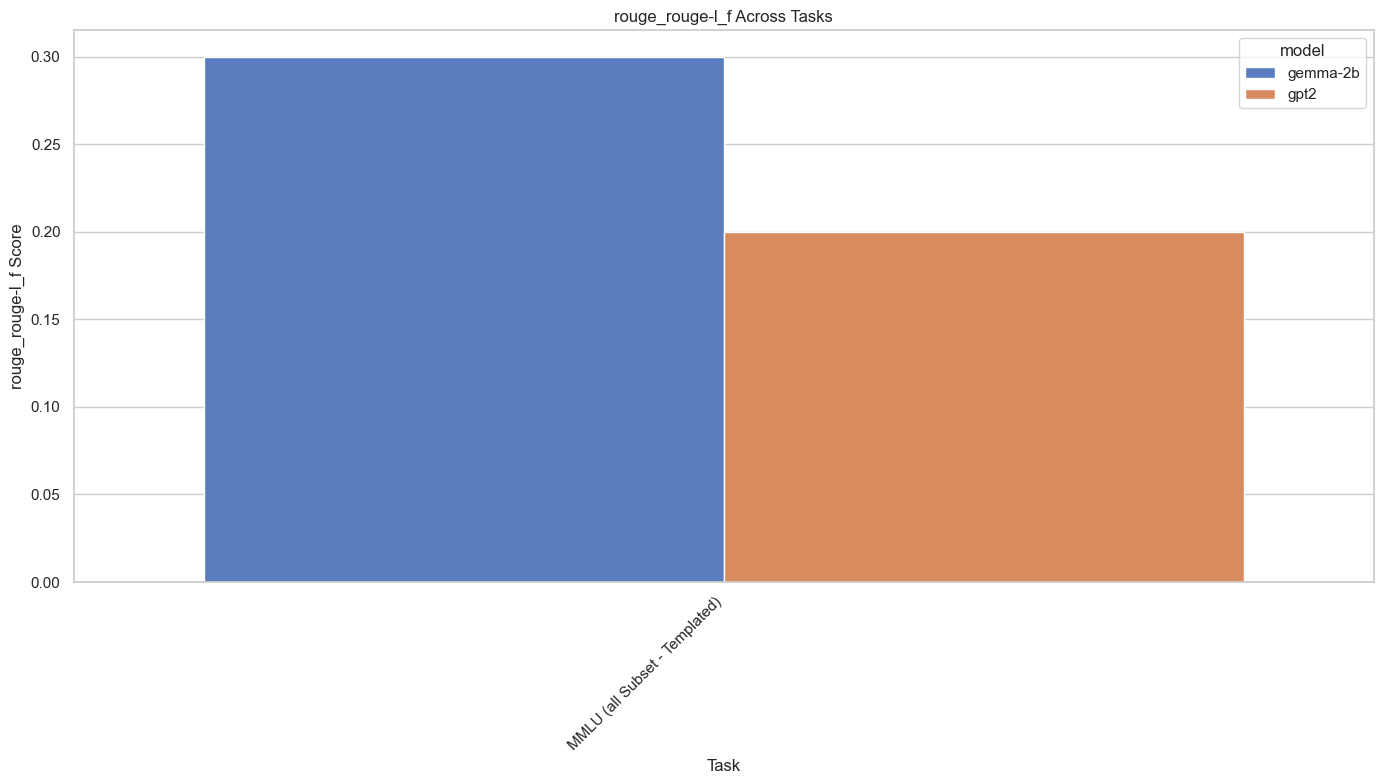


Metric: bleu


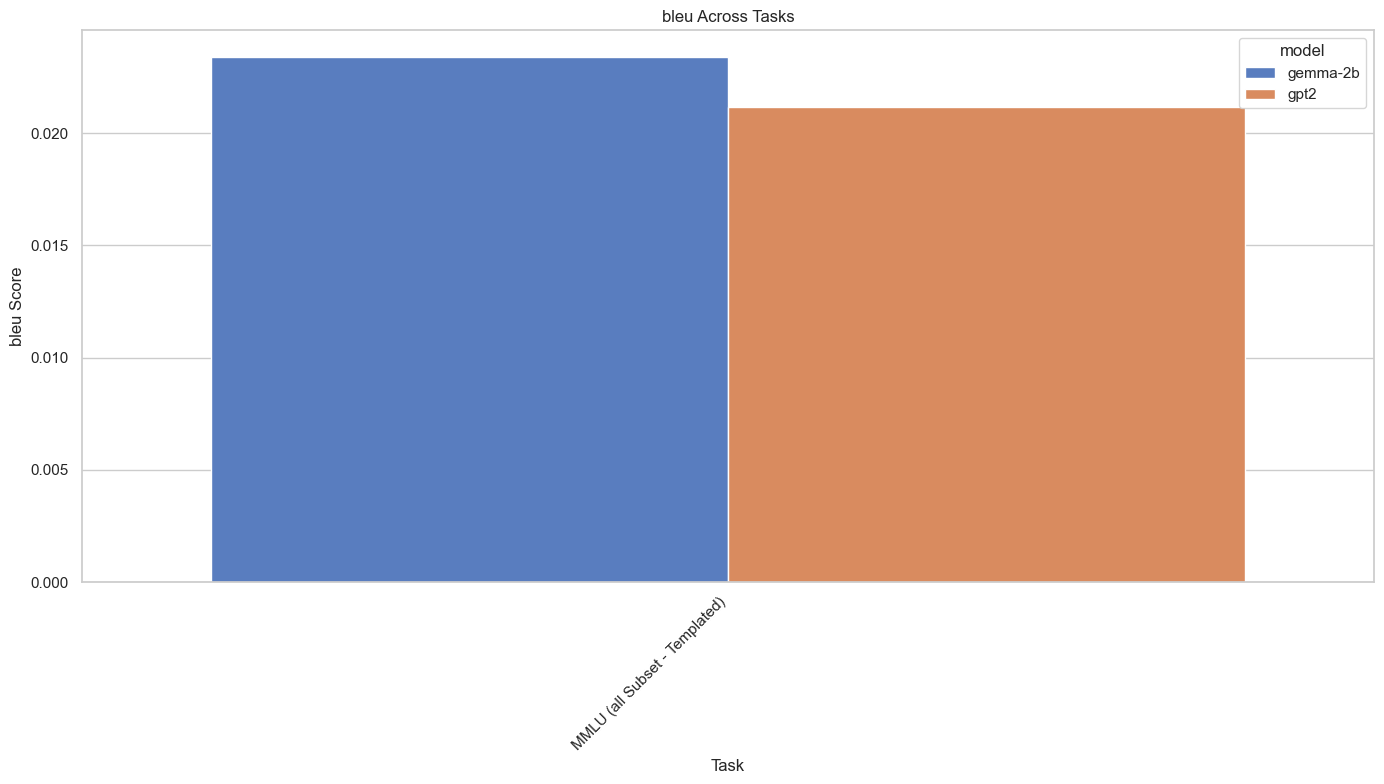


Metric: meteor


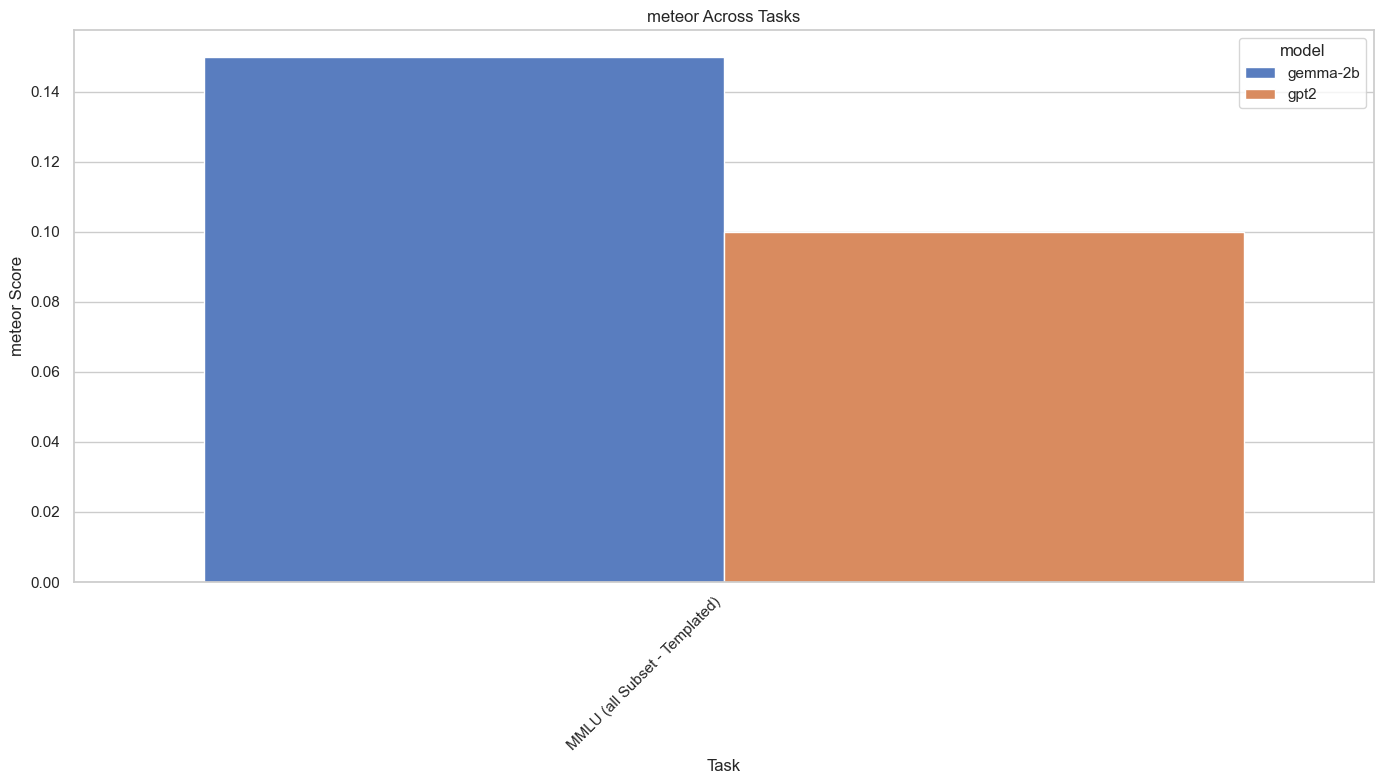


Metric: bert_score_bertscore_precision


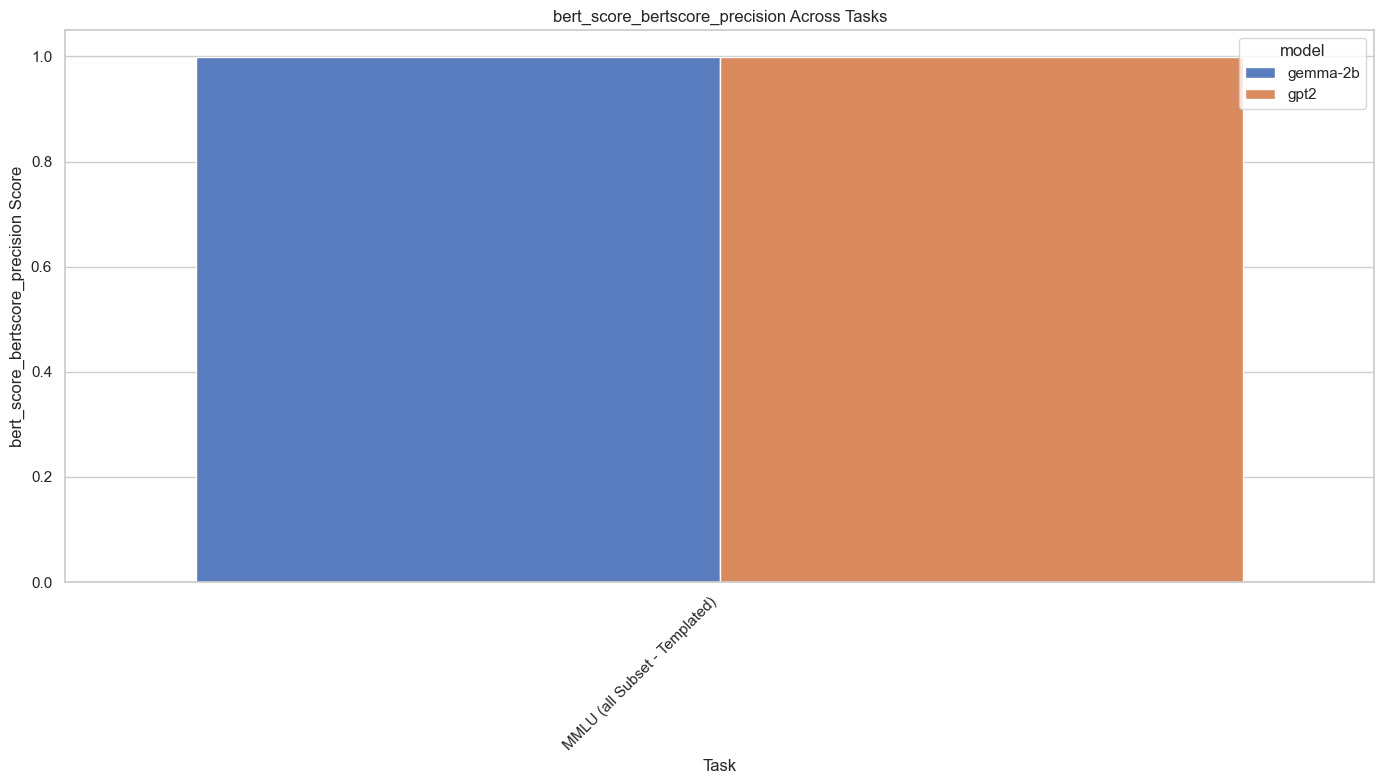


Metric: bert_score_bertscore_recall


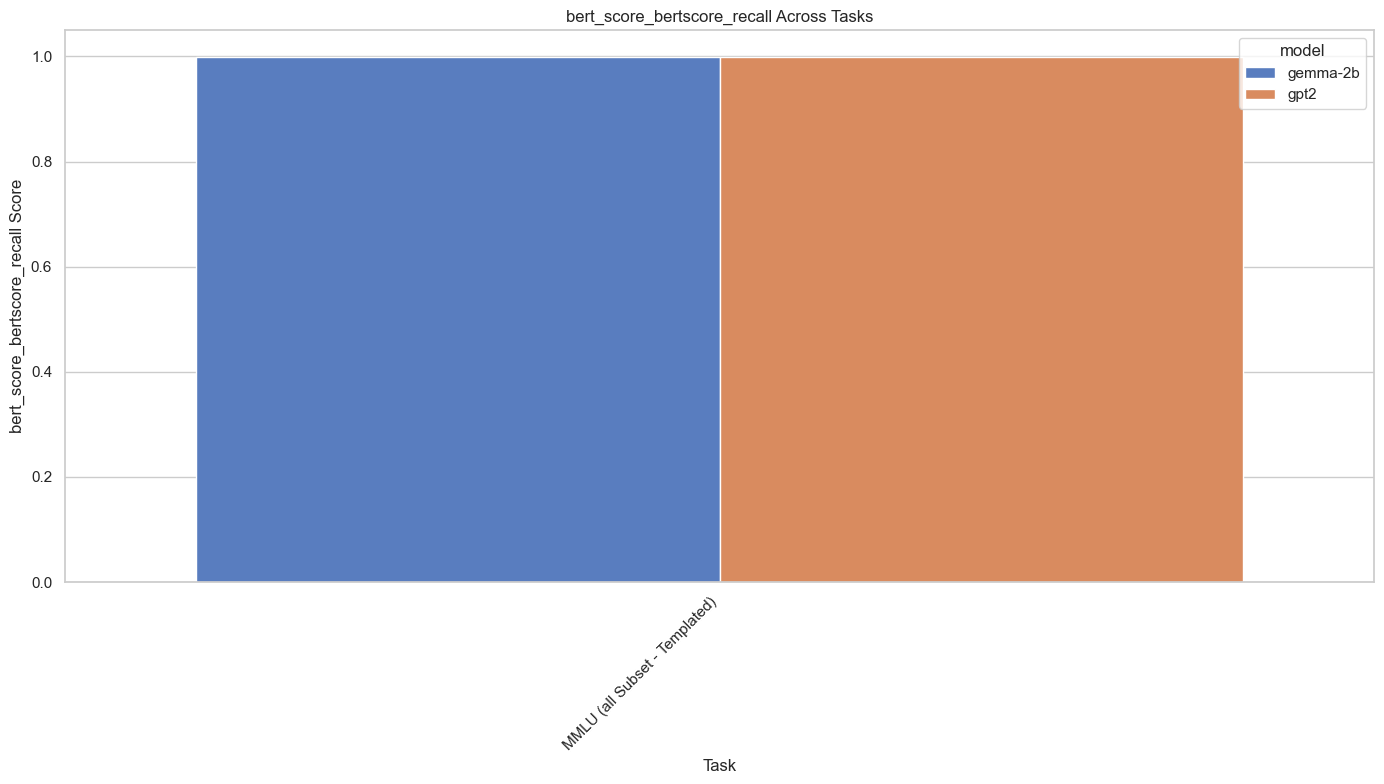


Metric: bert_score_bertscore_f1


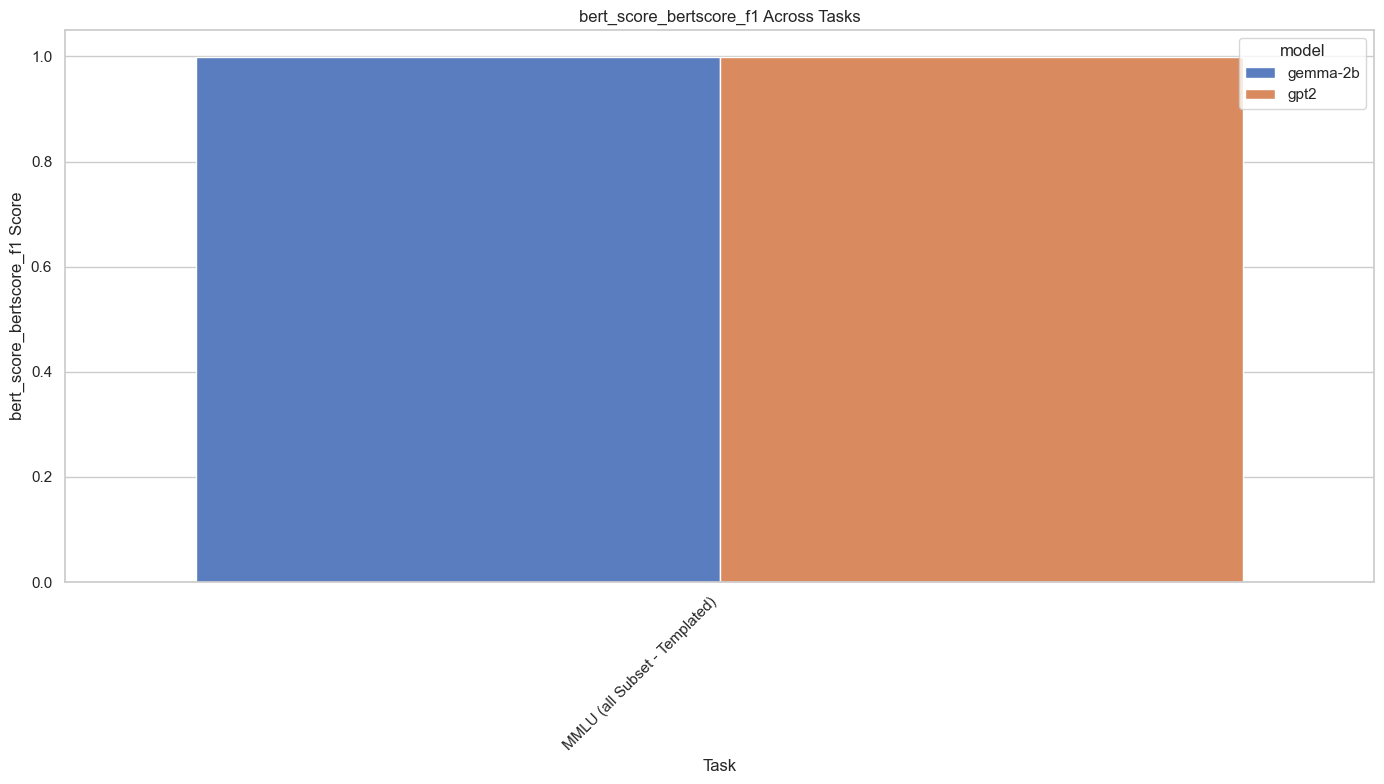


Metric: spearman_correlation


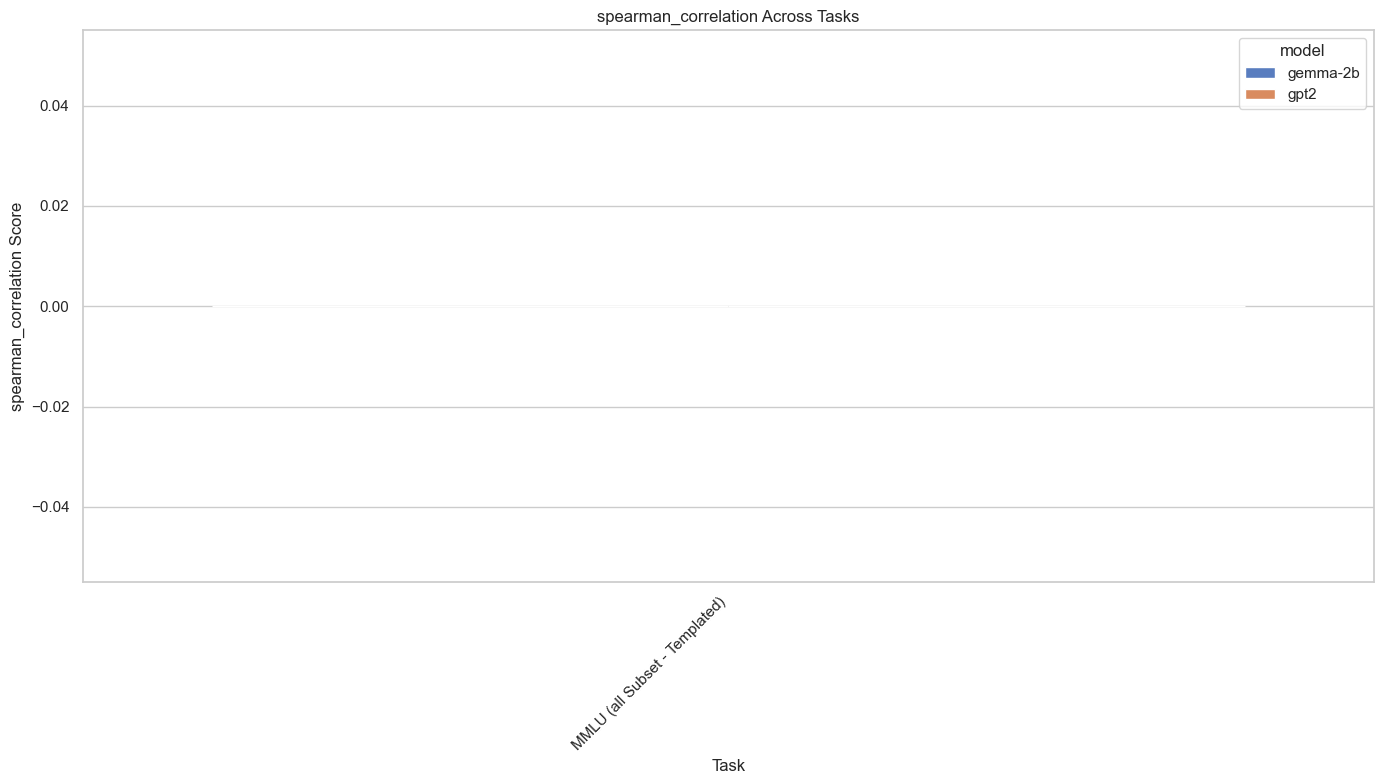


--- Generating heatmaps per metric ---

Heatmap for: exact_match


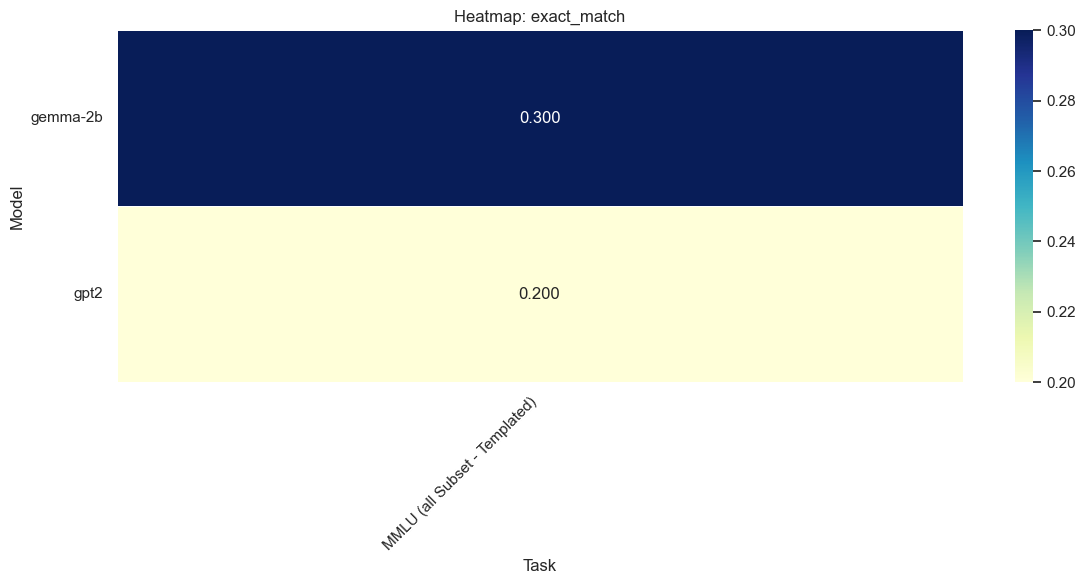


Heatmap for: accuracy


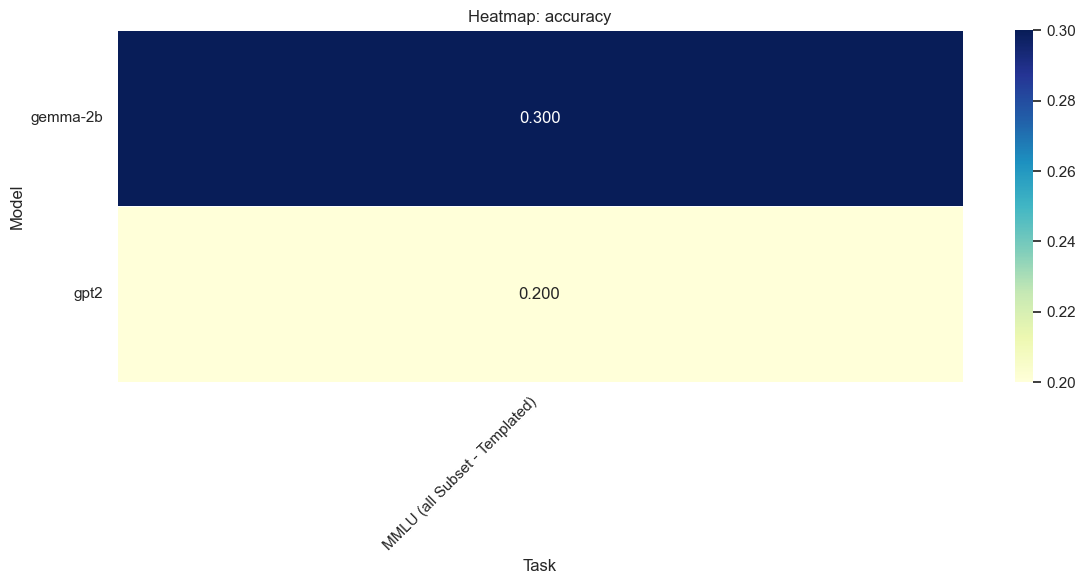


Heatmap for: f1_score


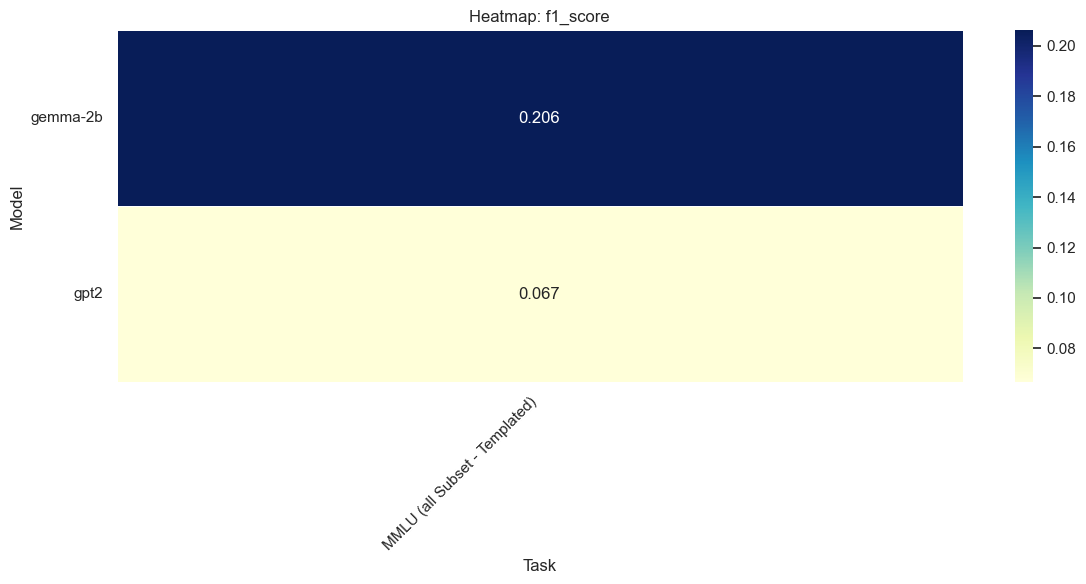


Heatmap for: precision


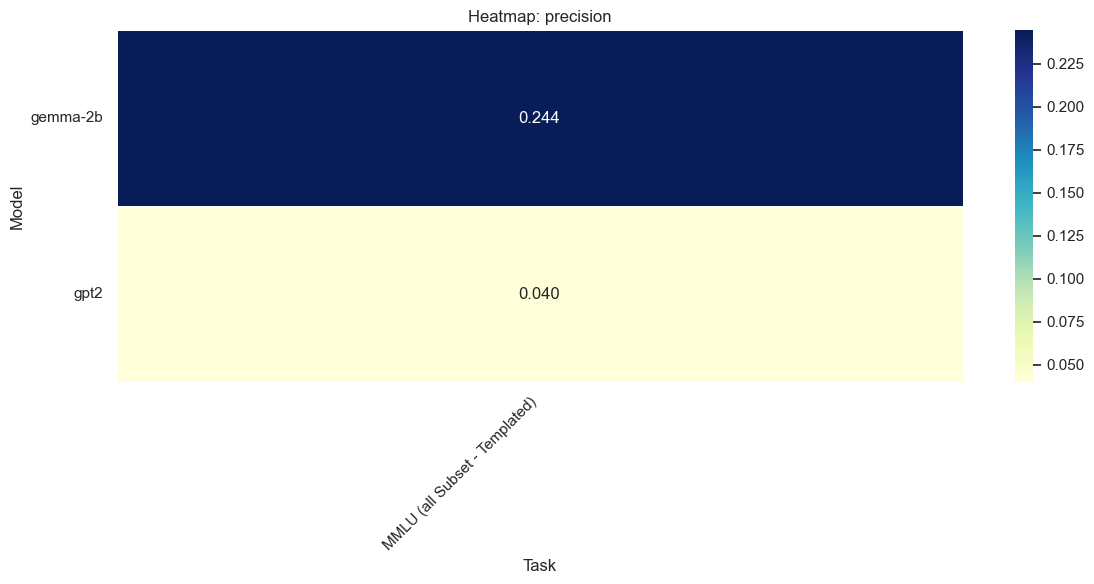


Heatmap for: recall


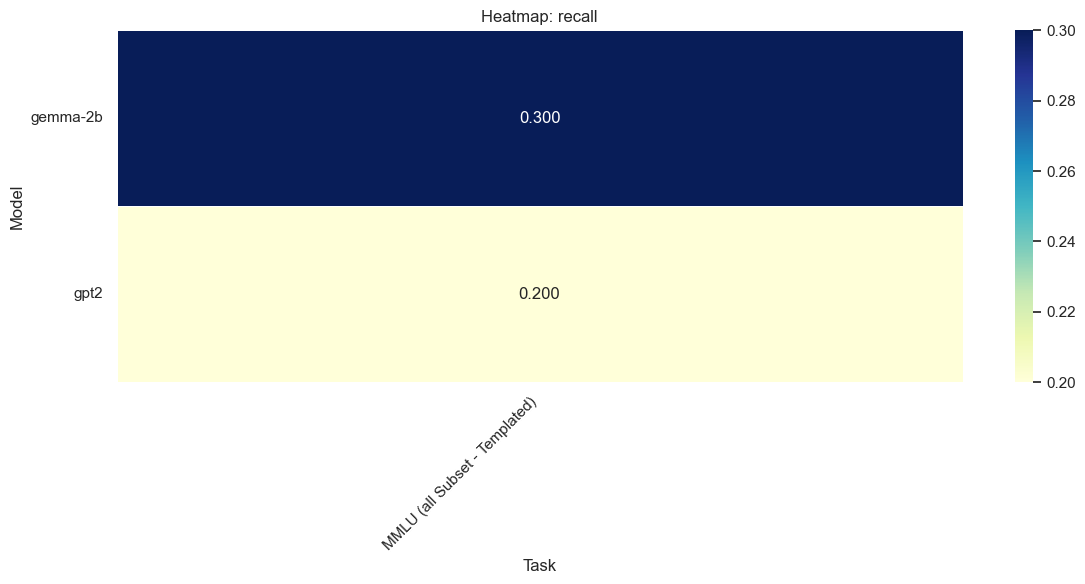


Heatmap for: rouge_rouge-l_f


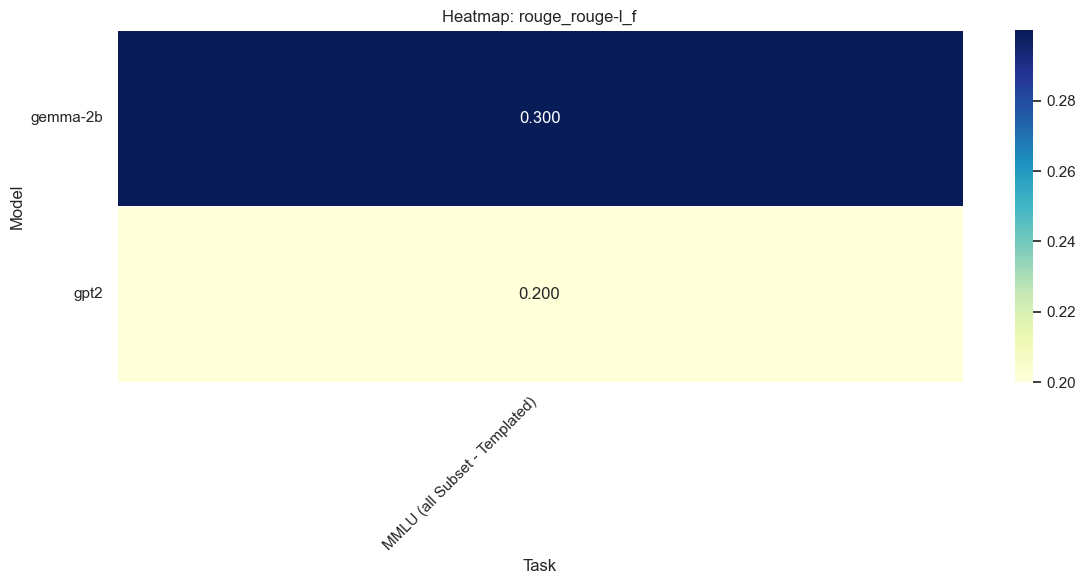


Heatmap for: bleu


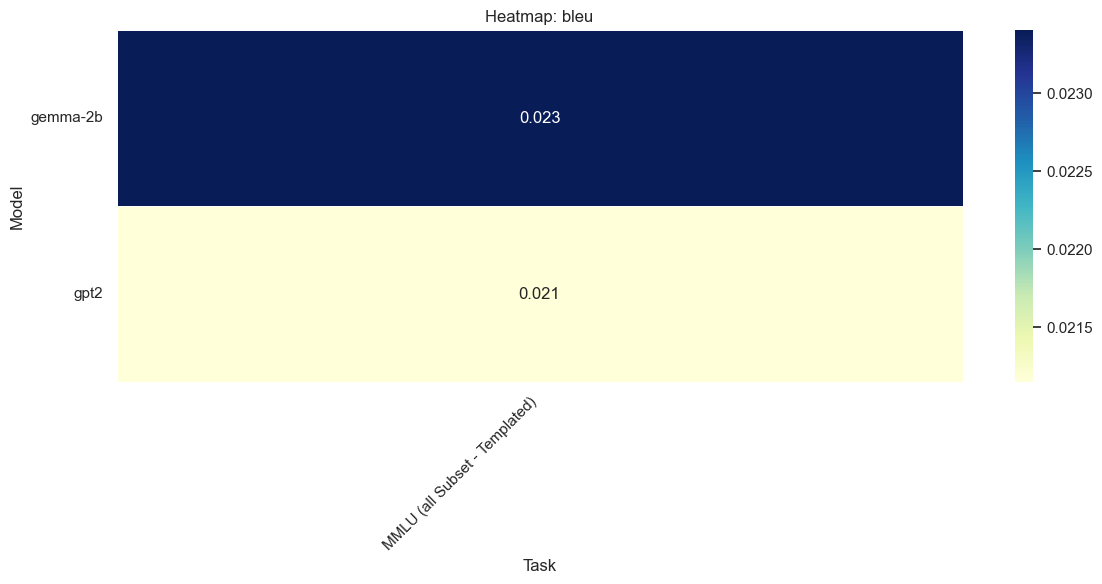


Heatmap for: meteor


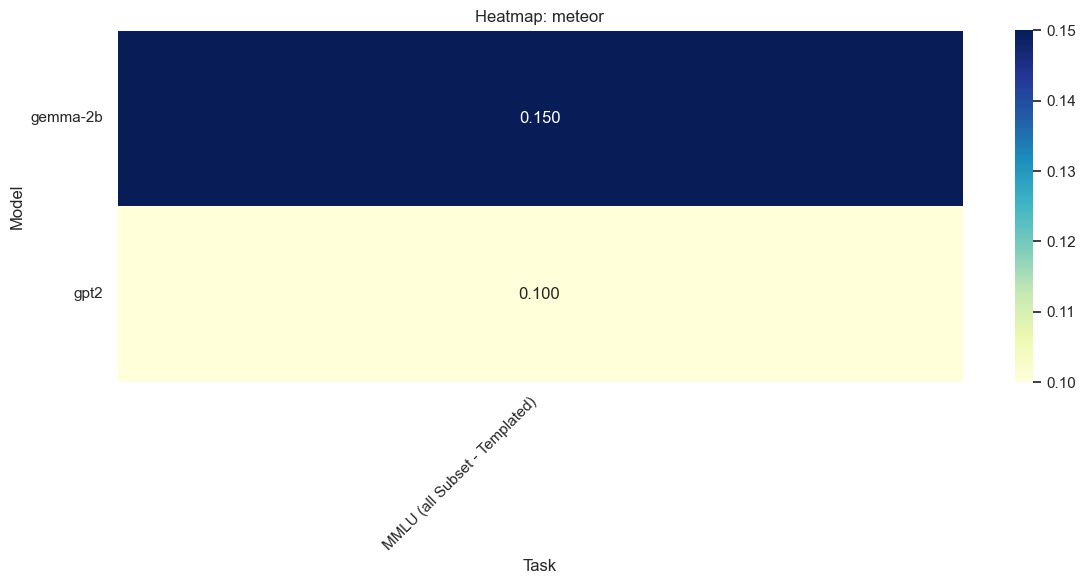


Heatmap for: bert_score_bertscore_precision


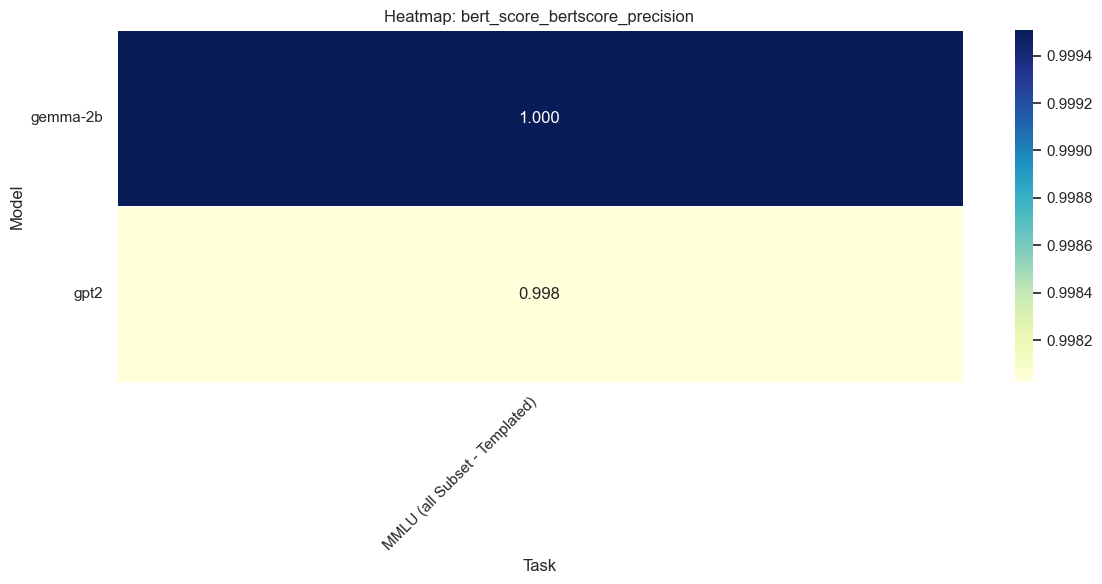


Heatmap for: bert_score_bertscore_recall


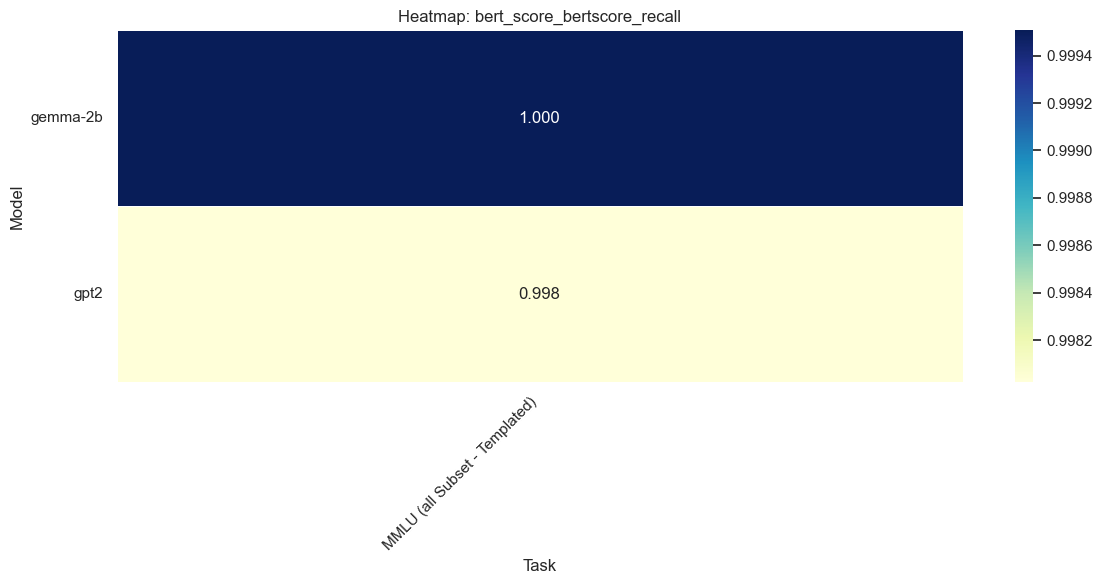


Heatmap for: bert_score_bertscore_f1


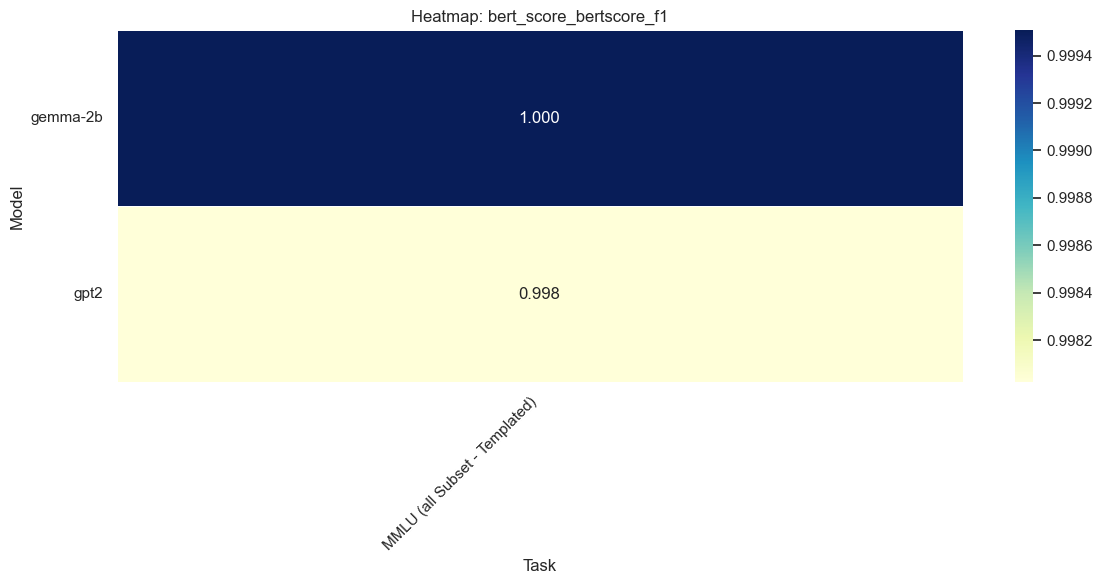


Heatmap for: spearman_correlation


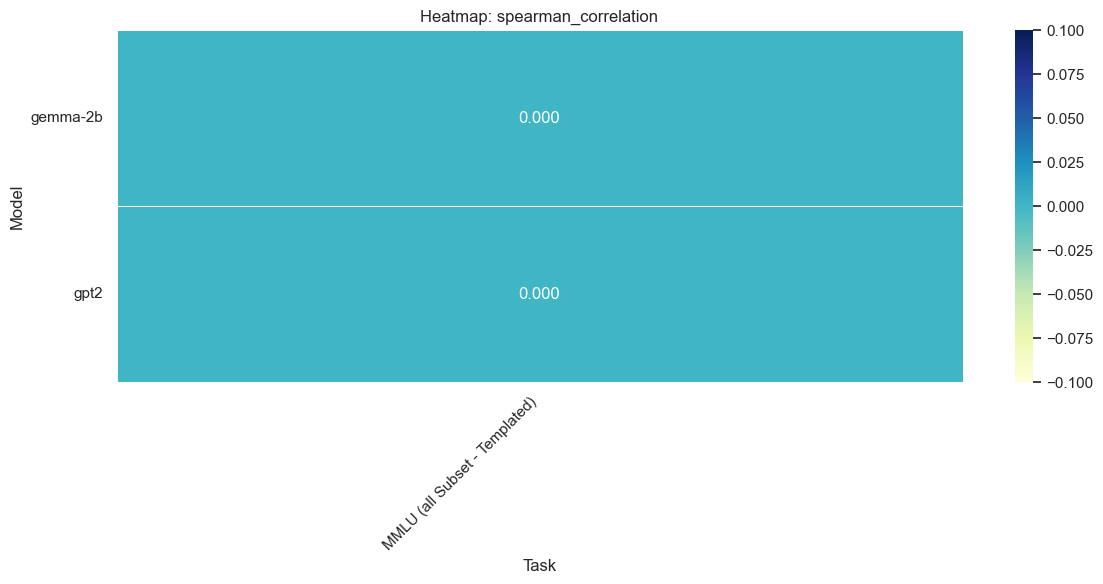

In [5]:
if results_df is not None and not results_df.empty and 'full_metric_name' in results_df.columns:
    print("\n" + "="*30)
    print("Generating All Plots")
    print("="*30 + "\n")
    
    all_tasks = results_df['task'].unique()
    all_metrics = results_df['full_metric_name'].unique()

    # --- 1. Bar plots per task ---
    for task in all_tasks:
        metrics = results_df[results_df['task'] == task]['full_metric_name'].unique()
        if metrics.size:
            print(f"\n--- Task: {task} ---")
            plot_task_metrics(results_df, task, metrics)
        else:
            print(f"\nNo metrics for task '{task}', skipping.")

    # --- 2. Grouped bar plots per metric ---
    print("\n--- Plotting each metric across tasks ---")
    for metric in all_metrics:
        print(f"\nMetric: {metric}")
        plot_metric_across_tasks(results_df, metric)

    # --- 3. Heatmaps per metric ---
    print("\n--- Generating heatmaps per metric ---")
    for metric in all_metrics:
        print(f"\nHeatmap for: {metric}")
        plot_heatmap_for_metric(results_df, metric)

else:
    print("Skipping plotting: DataFrame is empty or missing 'full_metric_name'.")